In [3]:
import shap
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from src.utils import order_templates
from src.utils_2 import encode_templates

# Load all ecg templates and labels

First, we load a dataset recording ECG during the use of a wheelchair.

There are six different levels (level 0 to 5), each level describing an increase in intensity (speed) with which the subject is driving. 0 is the stillstand level.

First, let's load the data.

In [7]:
with open('data/ecg_data.pkl', 'rb') as f:
    loaded_ecg_data = pickle.load(f)

templates_loaded = loaded_ecg_data['templates']
labels_loaded = loaded_ecg_data['labels']

class_template_mapping = order_templates(templates_loaded, labels_loaded)
z_class_template_mapping = encode_templates(class_template_mapping)

for key, value in z_class_template_mapping.items():
    print("Level:", key + 1, "| #templates: ", len(value))

Level: 1 | #templates:  391
Level: 5 | #templates:  335
Level: 2 | #templates:  411
Level: 4 | #templates:  401
Level: 3 | #templates:  269
Level: 0 | #templates:  282


We can now see which intensity levels (or classes) we have.

In addition, the number of templates per intensity level is listed.

Now, let's prepare the data for a simple plot.

In [8]:
numpy_mapping = {}
for key, value in z_class_template_mapping.items():
    key = key + 1
    numpy_mapping[key] = np.array(value)

# Only take 100 latent space samples per class (comp. too expensive otherwise)

numpy_mapping_small = {}
for key in numpy_mapping.keys():
    numpy_mapping_small[key] = numpy_mapping[key][:100]

for key, value in numpy_mapping_small.items():
    print(key, len(value))
numpy_mapping = numpy_mapping_small


1 100
5 100
2 100
4 100
3 100
0 100


# Plot two latent dimensions in a 2D plot

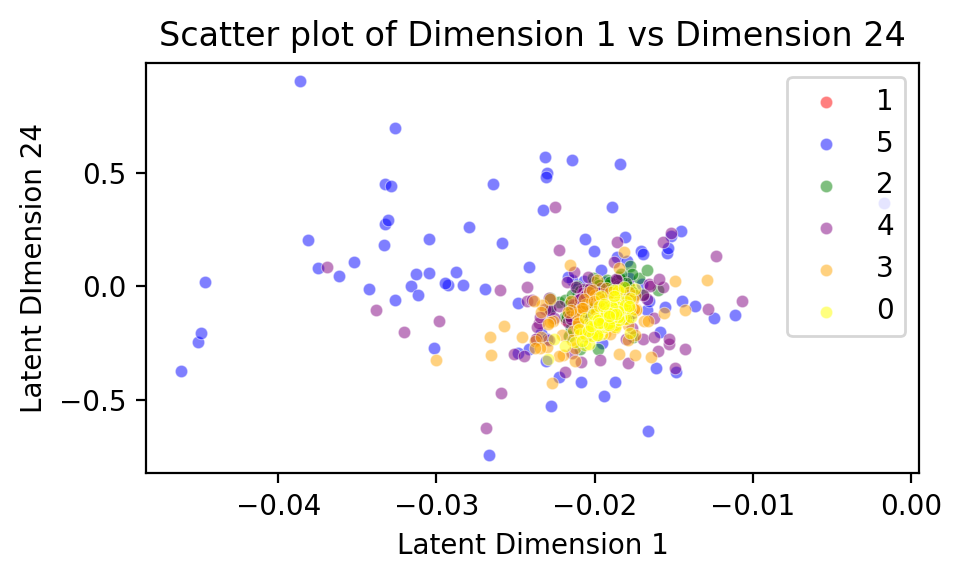

In [9]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(5,3))

# Define colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'brown', 'gray']
class_colors = {class_name: colors[i % len(colors)] for i, class_name in enumerate(numpy_mapping.keys())}

# Plot data for each class
for class_name, vectors in numpy_mapping.items():
    sns.scatterplot(x=vectors[:, 0], y=vectors[:, 23], label=class_name, color=class_colors[class_name], s=20, alpha=0.5, ax=ax)

# Add labels and legend
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent DImension 24')
ax.legend()
ax.set_title('Scatter plot of Dimension 1 vs Dimension 24')

# Show plot
plt.tight_layout()
plt.show()


# Classify Intensity Levels

We can see that there is some structure behind the data.

Now, we want to try to classify the ECG data based on the latent space representation.

In [10]:

# Define the number of dimensions
num_dimensions = 25

# Combine data into a single DataFrame
all_data = []
all_labels = []
for class_name, vectors in numpy_mapping.items():
    all_data.append(vectors)
    all_labels.extend([class_name] * len(vectors))

all_data = np.vstack(all_data)
all_labels = np.array(all_labels)

# Create a DataFrame
df = pd.DataFrame(all_data, columns=[f'dim{i+1}' for i in range(num_dimensions)])
df['label'] = all_labels

# Shuffle the DataFrame
df = shuffle(df, random_state=42)

# Split the dataset into features and labels
X = df.drop('label', axis=1)
y = df['label']

print(X.head(3))
print(y)


         dim1      dim2      dim3      dim4      dim5      dim6      dim7  \
110 -0.018482  0.003529 -0.064584 -0.012124  0.224074 -0.059270 -0.068979   
419 -0.018697  0.001542 -0.060100 -0.006670  0.144734 -0.056306  0.015709   
565 -0.018525 -0.001914 -0.064169 -0.014138  0.246722 -0.058531 -0.070735   

         dim8      dim9     dim10  ...     dim16     dim17     dim18  \
110 -0.027875  0.019132  0.030465  ... -0.716388  0.047677 -0.004359   
419 -0.023184  0.021910  0.036478  ... -0.706132  0.058554  0.006397   
565 -0.026960  0.018713  0.027563  ... -0.667181  0.038982 -0.008977   

        dim19     dim20     dim21     dim22     dim23     dim24     dim25  
110 -0.010561  0.009864 -0.027460 -0.015449 -0.040720  0.002423  0.014997  
419 -0.005236  0.007415 -0.023809 -0.014464 -0.105505 -0.182260  0.020051  
565 -0.010114  0.008211 -0.032750 -0.010810 -0.110174 -0.016586  0.021183  

[3 rows x 25 columns]
110    5
419    3
565    0
77     1
181    5
      ..
71     1
106    5
270

# Task 1: Write code to classify the dataset into the different intensity classes

In your first task, you should classify the dataset into three subclasses.

Please write code that:
1. splits the dataset into a training and test set (choose a reasonable split percentage)
2. trains a XGBoost classifier on it
3. shows the final test classification accuracy score

In [ ]:
"""
TODO: 
X_train, X_test, y_train, y_test = ...

model = ...
model.fit(X_train, y_train)

test_accuracy = ...
print(f'Test accuracy: {test_accuracy}')
"""

"""
Solution:
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Train XGBoost classifier:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

test_accuracy = ...
print(f'Test accuracy: {test_accuracy}')


In [ ]:
num_cores = joblib.cpu_count()

# Create a SHAP explainer with parallel computation
explainer = shap.Explainer(model, X_train)
#with joblib.parallel_backend('loky', n_jobs=num_cores):
shap_values = explainer(X_train)

Now, let us analyze the importance of the latent space dimensions for specific classes:

In [ ]:
# Plot the SHAP values for feature importance
# shap.summary_plot(shap_values, X_train, feature_names=X.columns)

# Shapley Analysis 

First, we want to find out which dimensions have a strong influence on the prediction of class 0 (standstill).

We can use a Beeswarm Plot for this.

In [ ]:
shap.plots.beeswarm(shap_values[:, :, 0])

We can see that for class 0, low (blue) dim8 values are very descriptive. Analogously, we find that the model leant that high dim1 values (red) are descriptive for class 0.

Let's check that visually in a 2D data plot as well.

In [ ]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(5,3))

# Define colors for each class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'black', 'pink', 'brown', 'gray']
class_colors = {class_name: colors[i % len(colors)] for i, class_name in enumerate(numpy_mapping.keys())}

# Plot data for each class
for class_name, vectors in numpy_mapping.items():
    sns.scatterplot(x=vectors[:, 7], y=vectors[:, 0], label=class_name, color=class_colors[class_name], s=20, alpha=0.5, ax=ax)

# Add labels and legend
ax.set_xlabel('Latent Dimension 8')
ax.set_ylabel('Latent DImension 1')
ax.legend()
ax.set_title('Scatter plot of Dimension 8 vs Dimension 1')

# Show plot
plt.tight_layout()
plt.show()

In the plot we can see that indeed, for class 0 (yellow), low dim8 and high dim0 values are observed frequently.

# Task 2: Shapley Analysis cont.

We have done an analysis for class 0 now.

TODO:
- Please repeat the analysis for class 3 now and also create a plot of descriptive features.

In [ ]:
"""
Write code for creating a beeswarm plot for class 0.
"""


In [ ]:
"""
Write code for plotting the identified descriptive dimensions for visualization purposes.
"""



# Individual Datapoint Analysis

Now, let us create a plot of an individual sample:

For that, we first identify the class of the first sample in our test set:

In [ ]:
print("True Class: ", y_test.iloc[0])
# print("Values: \n", X_test.iloc[0])

x = X_test.iloc[[0]]
y = model.predict(x)

print("Predicted Class: ", y[0])

Hence, we have seen that the true class of this datapoint is 5, which is also the predicted class.

Now, let us take a look at the dimensions that contribute mostly to this prediction using a waterfall plot..

In [ ]:
shap_values_x = explainer(x)
shap.plots.waterfall(shap_values_x[0, :, 4])

We can see that the specific values of the datapoint in dimensions dim25 ad dim1 strongly contribute to the classification.

f(x) is a measure for the prediction of the datapoint x being in the observed class (in this case class 4). Here, f(x) is very high and hence the datapoint is classified as class 4 as well.

Let's also make this analysis for the same datapoint for class 3:

In [ ]:
shap.plots.waterfall(shap_values_x[0, :, 3])

# Conclusion

We have seen that Shapley values and specifically the Python SHAP package can be used for explaining the XGBoost tree model, both for the whole dataset, for specific classes as well as for specific datapoints and individual feature contributions to the prediction.